# Electronic Structure Plotting

By Adriana J. Ladera

Center for Computational Science and Engineering, Massachusetts Institute of Technology

This is a tool to help plot the electronic structure computed from VASP calculations of structures, specifically band structure, the density of states, and the Brillouin zones. All final figures are saved to a directory created during runtime called 'figures-and-data'.

## Import libraries and shit

In [101]:
from pymatgen.io.vasp.outputs import BSVasprun
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.util.plotting import pretty_plot
import matplotlib.pyplot as plt
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter, DosPlotter
import pymatgen.electronic_structure.plotter as ESplotter
from pymatgen.io.vasp.outputs import BSVasprun, Vasprun
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.symmetry.bandstructure import HighSymmKpath
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import os
import statistics
from pymatgen.electronic_structure.core import OrbitalType
import math

## Helper functions

- sort_elements()

In [109]:
def sort_elements(poscar):
    '''Sorts elements between inorganic elements (metals, chalcogens)
        and organic elements.
        poscar: POSCAR file with VASP input'''
    inorganics = ['Ag', 'Au', 'Te', 'Se', 'S']
    inorgs, orgs = [], []
    with open(poscar) as f:
        lines = f.readlines()
        cunt = 0
        flag = 0
        for line in lines:
            for i in line.split():
                if str(i) in inorganics and cunt > 1:
                    flag = 1
            if flag:
                break
            cunt += 1
        for i in lines[cunt].split():
            if i in inorganics:
                inorgs.append(i)
            else:
                orgs.append(i)
    return inorgs, orgs

def sort_elements2(poscar):
    '''Sorts elements between inorganic elements (metals, chalcogens)
        and organic elements.
        poscar: POSCAR file with VASP input'''
    metals = ['Ag', 'Au', 'Hg']
    chalcogens = ['Te', 'Se', 'S']
    mets, chalcs, orgs = [], [],[]
    with open(poscar) as f:
        lines = f.readlines()
        cunt = 0
        flag = 0
        for line in lines:
            for i in line.split():
                if str(i) in metals and cunt > 1:
                    flag = 1
            if flag:
                break
            cunt += 1
        for i in lines[cunt].split():
            if i in metals:
                mets.append(i)
            elif i in chalcogens:
                chalcs.append(i)
            else:
                orgs.append(i)
    return mets, chalcs, orgs

def projections_to_array(projections):
    """Converts projection data to numpy array.
    
    projections: output of BandStructure.get_projection_on_elements()
    output: np.array of size [n_spin, n_bands, n_panes * distances, n_elements]
    """
    array = []
    for spin in projections.keys():
        spin_array = []
        for band in projections[spin]:
            band_array = []
            for d in band:
                band_array.append(np.array(list(d.values())))
            spin_array.append(np.stack(band_array, axis=0))
        array.append(np.stack(spin_array, axis=0))
    return np.stack(array, axis=0)

def get_element_projection_keys(projections):
    for spin in projections.keys():
        for band in projections[spin]:
            for d in band:
                return d.keys()
            
def estruct_data_to_csv(path, data, efermi):
    import subprocess as sp
    import pandas as pd

    result = sp.run(f"grep \"free energy\" {path}/scf/OUTCAR", shell=True, capture_output=True, text=True)
    output_lines = result.stdout.strip().split('\n')
    
    data_dict = {
        "vbm": data["vbm"][0][1],
        "cbm": data["cbm"][0][1],
        "eFermi": efermi,
        "bandgap": data["cbm"][0][1] - data["vbm"][0][1]#,
        # "energy": output_lines[-1].split()[-2]
    }

    df = pd.DataFrame(data_dict, index=[0])
    if not os.path.exists(f"{path}/figures-and-data"):
        os.mkdir(f"{path}/figures-and-data")
    df.to_csv(f"{path}/figures-and-data/estruct_energy_data.csv")

    return data["cbm"][0][1] - data["vbm"][0][1] # bandgap

def write_parchg_incar(path, diff_vbm, diff_cbm):
    lower_bound = diff_vbm - 0.00001
    upper_bound = diff_cbm + 0.00001
    if not os.path.exists(f"{path}/band-chg"):
        os.mkdir(f"{path}/band-chg")
    with open(f"{path}/band-chg/INCAR", 'w') as f:
        f.write(f"SYSTEM = STM simulation\n# must be the same as the SCF calc\n\nENCUT = 800\nISPIN = 1\nISYM = 2\nLPARD = .TRUE.\nNBMOD = -3\n# range and shit\nEINT = -{lower_bound} {upper_bound}\nLSEPB = .FALSE.\nLSEPK = .FALSE.")
    f.close()


In [108]:
ass = 1.140598

ass - 0.0001

1.140498

## Total force per atom

The OUTCAR provided by VASP often provides the force components (eV/Å) in the x, y, and z directions per site in a structure. To obtain the total force on a site, this can be calculated using:

$F = \sqrt{F_x^2 + F_y^2 + F_z^2}$

with the force components extracted from the OUTCAR file.

In [104]:
def total_force(forces):
    '''Total forces in eV / Angstrom on a site (atom)'''
    total_force = math.sqrt(forces[0]**2 + forces[1]**2 + forces[2]**2)
    net_force = forces[0] + forces[1] + forces[2]

    return total_force, net_force

def read_forces(outcar):
    '''from Github user gVallverdu: gVallverdu/read_forces.py'''
    forces = outcar.read_table_pattern(
    header_pattern=r"\sPOSITION\s+TOTAL-FORCE \(eV/Angst\)\n\s-+",
    row_pattern=r"\s+[+-]?\d+\.\d+\s+[+-]?\d+\.\d+\s+[+-]?\d+\.\d+\s+([+-]?\d+\.\d+)\s+([+-]?\d+\.\d+)\s+([+-]?\d+\.\d+)",
    footer_pattern=r"\s--+",
    postprocess=lambda x: float(x),
    last_one_only=False)

    return forces

def get_forces(outcar, structure, inorganics):
    forces = read_forces(outcar)

    # getting the total force eV/Angstrom per atom in the inorganic site
    for atom, f, in zip(range(len(structure)), forces[0]):
        force = total_force(f)
        for i in inorganics:
            if str(structure[atom].species)[:-1] == i:
                print(f"{str(structure[atom].species)[:-1]} has {round(force,4)} ev/Å: [F_x, F_y, F_z] = {f}")

## Band Structure
Groups elements by color for the finalized band structure

- Red bands are inorganic interactions, black bands are organic interactions, and colors are interpolated
- **Valence band maxima, VBM (green)** $\rightarrow$ the valence band maxima from which electrons can jump
- **Conduction band minima, CBM (blue)** $\rightarrow$ the conduction band minima to which electrons from the valence band can traverse to
- **band gap** $\rightarrow$ the gap in energy, measured from the VBM to the CBM. The band gap can be either indirect, in which the VBM(s) and CBM(s) are not aligned at the same k-point, or direct, in which they are. When an electron traverses the band gap, a photon is emitted, though with indrect band gap materials this usually requires a change in momentum and is often aided by phonons. This means that direct band gap materials are also more efficient at emitting light.

## 

In [67]:
def get_color_grouped(
    path,
    bandz,
    zero_to_efermi=True,
    ylim=None,
    xlim=None,
    smooth=False,
    vbm_cbm_marker=True,
    smooth_tol=0,
    smooth_k=3,
    smooth_np=100,
    bs_labels=None,
    marker_size=None,
):
    """
    By Tess Smidt, modified by Adriana Ladera.
    Get a matplotlib object for the bandstructures plot.
    Multiple bandstructure objs are plotted together if they have the
    same high symm path.
    Args:
        zero_to_efermi: Automatically subtract off the Fermi energy from
            the eigenvalues and plot (E-Ef).
        ylim: Specify the y-axis (energy) limits; by default None let
            the code choose. It is vbm-4 and cbm+4 if insulator
            efermi-10 and efermi+10 if metal
        smooth (bool or list(bools)): interpolates the bands by a spline cubic.
            A single bool values means to interpolate all the bandstructure objs.
            A list of bools allows to select the bandstructure obs to interpolate.
        smooth_tol (float) : tolerance for fitting spline to band data.
            Default is None such that no tolerance will be used.
        smooth_k (int): degree of splines 1<k<5
        smooth_np (int): number of interpolated points per each branch.
        bs_labels: labels for each band for the plot legend.
    """
    
    fuck, ax = plt.subplots(1, figsize=(12, 8), dpi=600)

    elements = sort_elements(f"{path}/band/POSCAR")
    inorganics = elements[0]
    organics = elements[1]
    # organics = elements[2]
    # group_dict = [{'elements':inorganics,'color':[255,20,147]},{'elements':organics,'color':[0,0,128]}]
    group_dict = [{'elements':inorganics,'color':[252, 56, 56]},{'elements':organics,'color':[0,0,0]}]
    
    if isinstance(smooth, bool):
        smooth = [smooth] * len(bandz._bs)

    handles = []
    vbm_min, cbm_max = [], []

    for ibs, bs in enumerate(bandz._bs):
        
        projections = bs.get_projection_on_elements()
        
        # Get projections into matrix form and order of elements in projections
        proj_array = projections_to_array(projections) # [n_spin, n_bands, n_distances, n_elements]
        elem_keys = list(get_element_projection_keys(projections)) # [n_elements]

        # Get groups and colors from group_dict
        color_matrix = np.array([np.array(g["color"]) for g in group_dict]) # [n_group, rgb]
        groups = [[elem_keys.index(elem) for elem in group['elements']] for group in group_dict]

        # Average color based on group occupation
        proj_totals = np.zeros(list(proj_array.shape[:-1]) + [len(groups)])
        for i, group in enumerate(groups):
            proj_totals[..., i] = proj_array[..., group].sum(axis=-1) / proj_array.sum(axis=-1)
        proj_colors = (proj_totals @ color_matrix) / 255 # [n_spin, n_bands, n_distances, 3]

        # set first bs in the list as ref for rescaling the distances of the other bands
        bs_ref = bandz._bs[0] if len(bandz._bs) > 1 and ibs > 0 else None

        if smooth[ibs]:
            # interpolation works good on short segments like branches
            data = bandz.bs_plot_data(zero_to_efermi, bs, bs_ref, split_branches=True)
        else:
            data = bandz.bs_plot_data(zero_to_efermi, bs, bs_ref, split_branches=False)
        
        # Rearrange colors based on shape of distances
        proj_colors_new = proj_colors.reshape(
            list(proj_colors.shape[:2]) 
            + list(np.array(data['distances']).shape) 
            + [proj_colors.shape[-1]])
        proj_colors_new_transpose = np.transpose(proj_colors_new, axes=[0, 2, 1, 3, 4])

        # remember if one bs is a metal for setting the ylim later
        one_is_metal = False
        if not one_is_metal and data["is_metal"]:
            one_is_metal = data["is_metal"]

        # remember all the cbm and vbm for setting the ylim later
        if not data["is_metal"]:
            cbm_max.append(data["cbm"][0][1])
            vbm_min.append(data["vbm"][0][1])
        else:
            cbm_max.append(bs.efermi)
            vbm_min.append(bs.efermi)
        
        print(f"Fermi energy {bs.efermi}")

        for i, sp in enumerate(bs.bands):
            ls = "-" if str(sp) == "1" else "--"

            if bs_labels is None:
                bs_label = f"Band {ibs} {sp.name}"
            else:
                # assume bs_labels is Sequence[str]
                bs_label = f"{bs_labels[ibs]} {sp.name}"

            # handles.append(mlines.Line2D([], [], lw=2, ls=ls, color=colors[ibs], label=bs_label))

            distances, energies = data["distances"], data["energy"][str(sp)]
            colors = proj_colors_new_transpose[i]

            if smooth[ibs]:
                _, r = bandz._interpolate_bands(
                    distances,
                    colors[..., 0],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                _, g = bandz._interpolate_bands(
                    distances,
                    colors[..., 1],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                _, b = bandz._interpolate_bands(
                    distances,
                    colors[..., 2],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                distances, energies = bandz._interpolate_bands(
                    distances,
                    energies,
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )
                # join all branches together
                distances = np.hstack(distances)
                energies = np.hstack(energies)
                colors = np.transpose(np.array([r, g, b]), [1, 2, 3, 0])
                # Interpolation can cause values to be outside valid rgb. Fix here.
                colors[colors < 0.] = 0.
                colors[colors > 1.] = 1.
            else:
                distances = np.array(distances).squeeze(0)
                energies = np.array(energies).squeeze(0)
                
            colors = np.transpose(colors, [1, 0, 2, 3])
            colors = colors.reshape(colors.shape[0], -1, 3)
            distances = np.repeat(distances.reshape(1, -1), energies.shape[0], axis=0)
            ax.scatter(distances.reshape(-1), energies.reshape(-1), c=colors.reshape(-1, 3), s=marker_size)

        vb_point, cb_point = [],[]
        # get markers for vbm and cbm
        if vbm_cbm_marker:
            for cbm in data["cbm"]:
                # ax.scatter(cbm[0], cbm[1], color="b", marker="o", s=80)
                cb_point.append([cbm[0], cbm[1]])
            for vbm in data["vbm"]:
                # ax.scatter(vbm[0], vbm[1], color="g", marker="o", s=80)
                vb_point.append([vbm[0], vbm[1]])

        # Draw Fermi energy, only if not the zero
        if not zero_to_efermi:
            ef = bs.efermi
            ax.axhline(bs.efermi, lw=1.5, ls="--", color='r')
            ax.text(0.05, bs.efermi+0.1, f'E_f = {round(bs.efermi,3)} eV', color='r', fontsize=20)

    # write data to CSV file
    bandgap = estruct_data_to_csv(path, data, bs.efermi)

    # defaults for ylim
    e_min = -4
    e_max = 4
    if one_is_metal:
        e_min = -10
        e_max = 10

    if ylim is None:
        if zero_to_efermi:
            if one_is_metal:
                # Plot A Metal
                ax.set_ylim(e_min, e_max)
            else:
                ax.set_ylim(e_min, max(cbm_max) + e_max)
        else:
            all_efermi = [b.efermi for b in bandz._bs]
            ll = min([min(vbm_min), min(all_efermi)])
            hh = max([max(cbm_max), max(all_efermi)])
            ax.set_ylim(ll + e_min, hh + e_max)
    else:
        ax.set_ylim(ylim)

    xticks = bandz.get_ticks()
    ax.set_xticks(xticks['distance'])
    ax.set_xticklabels(xticks['label'], fontsize=20)

    print(f"K-point labels: {xticks['label']}")
    print(len(xticks['label']))

    # X range (K)
    if xlim is None:
        x_max = data["distances"][-1][-1]
        ax.set_xlim(0, x_max)

        min_vbm_x = min([vbm[0] for vbm in vb_point])
        max_vbm_x = max([vbm[0] for vbm in vb_point])
        min_cbm_x = min([cbm[0] for cbm in cb_point])
        max_cbm_x = max([cbm[0] for cbm in cb_point])
    else:
        x_min_range = xticks['distance'][xlim[0]]
        x_max_range = xticks['distance'][xlim[1]]
        ax.set_xlim(x_min_range,x_max_range)

        min_vbm_x = min([vbm[0] for vbm in vb_point if x_min_range <= vbm[0] <= x_max_range])
        max_vbm_x = max([vbm[0] for vbm in vb_point if x_min_range <= vbm[0] <= x_max_range])
        min_cbm_x = min([cbm[0] for cbm in cb_point if x_min_range <= cbm[0] <= x_max_range])
        max_cbm_x = max([cbm[0] for cbm in cb_point if x_min_range <= cbm[0] <= x_max_range])

    for tit in xticks['distance']:
        ax.axvline(x = tit, color = '#000000', linestyle = '-')
    ax.set_yticklabels(ax.get_yticks(), fontsize=20)

    # Main X and Y Labels
    ax.set_xlabel(r"$\mathrm{Wave\ Vector}$", fontsize=24)
    ylabel = r"$\mathrm{E\ -\ E_f\ (eV)}$" if zero_to_efermi else r"$\mathrm{Energy\ (eV)}$"
    ax.set_ylabel(ylabel, fontsize=24)

    # # band gap information
    ax.plot([min(min_cbm_x,min_vbm_x)+0.04, max(min_cbm_x,min_vbm_x)-0.04], [cb_point[0][1],cb_point[0][1]], color = '#666666', linestyle = '-.', lw=3) 
    ax.plot([min(min_cbm_x,min_vbm_x)+0.04, max(min_cbm_x,min_vbm_x)-0.04], [vb_point[0][1],vb_point[0][1]], color = '#666666', linestyle = '-.', lw=3) 
    ax.annotate('', xy=(min(min_cbm_x,min_vbm_x)+0.1,cb_point[0][1]), xytext=(min(min_cbm_x,min_vbm_x)+0.1,vb_point[0][1]), arrowprops=dict(arrowstyle='<->', color='#000000', lw=3))
    ax.text(min(min_cbm_x,min_vbm_x)+0.2, (cb_point[0][1]+vb_point[0][1])/2, f'{bandgap:.3f} eV', color='#666666', fontsize=20)

    # getting VBM and CBM
    for v in vb_point:
        ax.scatter(v[0], v[1], color="b", marker="o", s=100)
    for c in cb_point:
        ax.scatter(c[0], c[1], color="g", marker="o", s=100)

    # changing spine thickness
    for spine in ax.spines.values():
        spine.set_linewidth(3)

    fuck.tight_layout()

    if not os.path.exists(f"{path}/figures-and-data"):
        os.mkdir(f"{path}/figures-and-data")
    fuck.savefig(f"{path}/figures-and-data/colored_bandstructure.png", dpi=600)

## Density of States

[some blurb about DOS here] Like the band diagram, DOS also shows the band gap of materials.

Based on the DOSPlotter() module from Pymatgen, except much prettier YEEHAW

Takes in a DOSPlotter object and produces a matplotlib plot that plots the density of states by element in the material. The final figure is saved to a directory created during runtime called 'figures-and-data'.

In [4]:
def pretty_dos_plot(path, dosplot):
    '''Get element DOS and plot according to whether
        the element is a metal, chalcogen, or organic.
        Axes are scaled automatically according to the range
        of energies and densities. '''
    fuck, ax = plt.subplots(1, figsize=(11, 8), dpi=600)
    colors = ['#00C120', "#00B6FF", "#9E00FF"] # green, blue, purple (idk what order whoops)
    cunt = 0
    max_dos = []

    for elem in dosplot.get_dos_dict():
        if elem in ['Ag', 'Au', 'Hg']: # red
            col = "#FF0000" # orange
        elif elem in ['Se', 'Te', 'S']: # chalcogens
            col = "#FC8F04" # orange
        else: # organics
            col = colors[cunt]
            cunt += 1
        y = dosplot.get_dos_dict()[elem]['densities']['1']
        x =  dosplot.get_dos_dict()[elem]['energies']
        max_dos.append(max(y))
        ax.plot(x, y, label=elem, c=col, linewidth=2.5)

    ax.set_ylabel(r"Density of States (energies / eV)", fontsize=18)
    ax.set_xlabel(r"Energies (eV)", fontsize=18)
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)

    # scale limits according to min and max of energies and densities
    ax.set_ylim(0, max(max_dos)*1.05)
    ax.set_xlim(min(x), max(x))

    # plot Fermi energy
    ax.axvline(x = dosplot.get_dos_dict()['Ag']['efermi'], color = '#000000', linestyle = '-.', label='$E_{Fermi}$',linewidth=1.5)

    ax.grid()
    ax.legend(loc='upper right', fontsize=18)
    fuck.tight_layout()

    if not os.path.exists(f"{path}/figures-and-data"):
        os.mkdir(f"{path}/figures-and-data")
    fuck.savefig(f"{path}/figures-and-data/total_dos.png", dpi=600)


## Plot DOS and band structure in the same plot

- color_bs_dos_plotter() $\rightarrow$ Combines both the functions from the DOS plotter and the band structure plotter and produces a figure with both plots. Returns *xticks['label']*, which can be used to determine the selected labels to be plotted in the following function.
- color_bs_dos_plotter_simple() $\rightarrow$ same as color_bs_dos_plotter(), but has an additional parameter, *band_xlim*, which allows you to select which band labels (i.e., the "x-range") will be shown in the final figure.

In [95]:
def color_bs_dos_plotter(
    path,
    bandz,
    dos,
    band_xlim,
    zero_to_efermi=True,
    ylim=None,
    dos_ylim=None,
    dos_xlim=None,
    smooth=False,
    vbm_cbm_marker=True,
    smooth_tol=0,
    smooth_k=3,
    smooth_np=100,
    bs_labels=None,
    marker_size=None,
):
    """
    Color plot grouping by Tess Smidt, modified by Adriana Ladera. 
    Dos Plotter by Adriana Ladera.
    Get a matplotlib object for the bandstructures plot.
    Multiple bandstructure objs are plotted together if they have the
    same high symm path.
    Args:
        zero_to_efermi: Automatically subtract off the Fermi energy from
            the eigenvalues and plot (E-Ef).
        ylim: Specify the y-axis (energy) limits; by default None let
            the code choose. It is vbm-4 and cbm+4 if insulator
            efermi-10 and efermi+10 if metal
        smooth (bool or list(bools)): interpolates the bands by a spline cubic.
            A single bool values means to interpolate all the bandstructure objs.
            A list of bools allows to select the bandstructure obs to interpolate.
        smooth_tol (float) : tolerance for fitting spline to band data.
            Default is None such that no tolerance will be used.
        smooth_k (int): degree of splines 1<k<5
        smooth_np (int): number of interpolated points per each branch.
        bs_labels: labels for each band for the plot legend.
    """
    fuck, (a0, a1) = plt.subplots(1, 2, figsize=(12,8), dpi=600, gridspec_kw={'width_ratios': [5, 3]})

    ############ Plotting the DOS ############
    colors = ['#FF1493', "#CC0000", "#FF7F50", "#FFD700", "#008000", "#2ACAEA", "#0000FF", "#8A2BE2"]
    cunt = 0
    for orb in dos.get_dos_dict():
        cunt += 1
        x = dos.get_dos_dict()[orb]['densities']['1']
        y =  dos.get_dos_dict()[orb]['energies']
        a1.plot(x, y, label=orb, c=colors[cunt], linewidth=4)
    a1.set_xlabel(r"DOS (E/eV)", fontsize=24)
    a1.set_xlim(dos_xlim[0], dos_xlim[1])
    if dos_ylim is not None:
        a1.set_ylim(dos_ylim[0], dos_ylim[1])
        a1.set_ylabel(r"Energies (eV)", fontsize=24)
    else:
        a1.set_ylim(ylim[0], ylim[1])
    a1.set_xticklabels(np.arange(dos_xlim[0], dos_xlim[1]), fontsize=20)
    a1.set_yticklabels(np.arange(ylim[0], ylim[1]), fontsize=20)

    if not zero_to_efermi:
        a1.axhline(y = dos.get_dos_dict()['Ag']['efermi'], color = 'r', linestyle = '--', label='$E_{Fermi}$',linewidth=1.5)
        
    a1.grid()
    a1.legend(loc='upper right', fontsize=20)

    ################### Plotting the band structure ###############
    elements = sort_elements(f"{path}/band/POSCAR")
    inorganics = elements[0]
    organics = elements[1]
    group_dict = [{'elements':inorganics,'color':[252, 56, 56]},{'elements':organics,'color':[0,0,0]}]
    
    if isinstance(smooth, bool):
        smooth = [smooth] * len(bandz._bs)

    handles = []
    vbm_min, cbm_max = [], []

    for ibs, bs in enumerate(bandz._bs):
        
        projections = bs.get_projection_on_elements()
        
        # Get projections into matrix form and order of elements in projections
        proj_array = projections_to_array(projections) # [n_spin, n_bands, n_distances, n_elements]
        elem_keys = list(get_element_projection_keys(projections)) # [n_elements]

        # Get groups and colors from group_dict
        color_matrix = np.array([np.array(g["color"]) for g in group_dict]) # [n_group, rgb]
        groups = [[elem_keys.index(elem) for elem in group['elements']] for group in group_dict]

        # Average color based on group occupation
        proj_totals = np.zeros(list(proj_array.shape[:-1]) + [len(groups)])
        for i, group in enumerate(groups):
            proj_totals[..., i] = proj_array[..., group].sum(axis=-1) / proj_array.sum(axis=-1)
        proj_colors = (proj_totals @ color_matrix) / 255 # [n_spin, n_bands, n_distances, 3]

        # set first bs in the list as ref for rescaling the distances of the other bands
        bs_ref = bandz._bs[0] if len(bandz._bs) > 1 and ibs > 0 else None

        if smooth[ibs]:
            # interpolation works good on short segments like branches
            data = bandz.bs_plot_data(zero_to_efermi, bs, bs_ref, split_branches=True)
        else:
            data = bandz.bs_plot_data(zero_to_efermi, bs, bs_ref, split_branches=False)
        
        # Rearrange colors based on shape of distances
        proj_colors_new = proj_colors.reshape(
            list(proj_colors.shape[:2]) 
            + list(np.array(data['distances']).shape) 
            + [proj_colors.shape[-1]])
        proj_colors_new_transpose = np.transpose(proj_colors_new, axes=[0, 2, 1, 3, 4])

        # remember if one bs is a metal for setting the ylim later
        one_is_metal = False
        if not one_is_metal and data["is_metal"]:
            one_is_metal = data["is_metal"]

        # remember all the cbm and vbm for setting the ylim later
        if not data["is_metal"]:
            cbm_max.append(data["cbm"][0][1])
            vbm_min.append(data["vbm"][0][1])
        else:
            cbm_max.append(bs.efermi)
            vbm_min.append(bs.efermi)
        
        print(f"Fermi energy: {bs.efermi}")
        diff_vbm = bs.efermi- data["vbm"][0][1]
        print(f"VBM diff: {diff_vbm}")
        diff_cbm = data["cbm"][0][1] - bs.efermi
        print(f"CBM diff: {diff_cbm}")

        write_parchg_incar(diff_vbm, diff_cbm)

        xticks = bandz.get_ticks()
        labels = xticks["label"]
        print(f"BAND LABELS: {xticks['label']}")
        print(f"LAST INDEX OF LABELS LIST: {len(labels)-1}")

        for i, sp in enumerate(bs.bands):
            ls = "-" if str(sp) == "1" else "--"

            if bs_labels is None:
                bs_label = f"Band {ibs} {sp.name}"
            else:
                # assume bs_labels is Sequence[str]
                bs_label = f"{bs_labels[ibs]} {sp.name}"

            # handles.append(mlines.Line2D([], [], lw=2, ls=ls, color=colors[ibs], label=bs_label))

            distances, energies = data["distances"], data["energy"][str(sp)]
            colors = proj_colors_new_transpose[i]

            if smooth[ibs]:
                _, r = bandz._interpolate_bands(
                    distances,
                    colors[..., 0],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                _, g = bandz._interpolate_bands(
                    distances,
                    colors[..., 1],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                _, b = bandz._interpolate_bands(
                    distances,
                    colors[..., 2],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                distances, energies = bandz._interpolate_bands(
                    distances,
                    energies,
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )
                # join all branches together
                distances = np.hstack(distances)
                energies = np.hstack(energies)
                colors = np.transpose(np.array([r, g, b]), [1, 2, 3, 0])
                # Interpolation can cause values to be outside valid rgb. Fix here.
                colors[colors < 0.] = 0.
                colors[colors > 1.] = 1.
            else:
                distances = np.array(distances).squeeze(0)
                energies = np.array(energies).squeeze(0)
                
            colors = np.transpose(colors, [1, 0, 2, 3])
            colors = colors.reshape(colors.shape[0], -1, 3)
            distances = np.repeat(distances.reshape(1, -1), energies.shape[0], axis=0)
            a0.scatter(distances.reshape(-1), energies.reshape(-1), c=colors.reshape(-1, 3), s=marker_size)

        vb_point, cb_point = [],[]
        # plot markers for vbm and cbm
        if vbm_cbm_marker:
            for cbm in data["cbm"]:
                # a0.scatter(cbm[0], cbm[1], color="b", marker="o", s=80)
                cb_point.append([cbm[0], cbm[1]])
            for vbm in data["vbm"]:
                # a0.scatter(vbm[0], vbm[1], color="g", marker="o", s=80)
                vb_point.append([vbm[0], vbm[1]])

        # Draw Fermi energy, only if not the zero
        if not zero_to_efermi:
            ef = bs.efermi
            # a0.axhline(ef, lw=2, ls="--", color=colors[ibs])
            a0.axhline(bs.efermi, lw=1.5, ls="--", color='r')
            a0.text(0.05, bs.efermi+0.1, f'E_f = {round(bs.efermi,3)} eV', color='r', fontsize=20)

    # write data to CSV file
    bandgap = estruct_data_to_csv(path, data, bs.efermi)

    # defaults for ylim
    e_min = -4
    e_max = 4
    if one_is_metal:
        e_min = -10
        e_max = 10

    if ylim is None:
        if zero_to_efermi:
            if one_is_metal:
                # Plot A Metal
                a0.set_ylim(e_min, e_max)
            else:
                a0.set_ylim(e_min, max(cbm_max) + e_max)
        else:
            all_efermi = [b.efermi for b in bandz._bs]
            ll = min([min(vbm_min), min(all_efermi)])
            hh = max([max(cbm_max), max(all_efermi)])
            a0.set_ylim(ll + e_min, hh + e_max)
    else:
        a0.set_ylim(ylim)

    a0.set_xticks(xticks['distance'])
    a0.set_xticklabels(xticks['label'], fontsize=20)

    # setting the range to display the selected band labels
    if band_xlim is None:
        x_min_range = xticks['distance'][0]
        x_max_range = xticks['distance'][-1]
    else:
        x_min_range = xticks['distance'][band_xlim[0]]
        x_max_range = xticks['distance'][band_xlim[1]]
    a0.set_xlim(x_min_range,x_max_range)

    # returning labels to use for brillouin zone
    labels_list = []
    for i,j in zip(xticks["distance"], xticks["label"]):
        if x_min_range <= i <= x_max_range:
            labels_list.append(j)

    for tit in xticks['distance']:
        a0.axvline(x = tit, color = '#000000', linestyle = '-')
    a0.set_yticklabels(a0.get_yticks(), fontsize=20)

    # Main X and Y Labels
    a0.set_xlabel(r"$\mathrm{Wave\ Vector}$", fontsize=24)
    ylabel = r"$\mathrm{E\ -\ E_f\ (eV)}$" if zero_to_efermi else r"$\mathrm{Energy\ (eV)}$"
    a0.set_ylabel(ylabel, fontsize=24)

    # band gap information
    a0.axhline(y = cb_point[0][1], color = '#666666', linestyle = '-.', lw=3)
    a0.axhline(y = vb_point[0][1], color = '#666666', linestyle = '-.', lw=3)
    a0.annotate('', xy=(x_min_range+0.1,cb_point[0][1]), xytext=(x_min_range+0.1,vb_point[0][1]), arrowprops=dict(arrowstyle='<->', color='#000000', lw=3))
    a0.text(x_min_range+0.2, (cb_point[0][1]+vb_point[0][1])/2, f'{bandgap:.3f} eV', color='#666666', fontsize=20)

    for c in cb_point:
        a0.scatter(c[0], c[1], color="b", marker="o", s=100)
    for v in vb_point:
        a0.scatter(v[0], v[1], color="g", marker="o", s=100)

    # changing spine thickness
    for ax in [a0, a1]:
        for spine in ax.spines.values():
            spine.set_linewidth(3)

    fuck.tight_layout()

    if not os.path.exists(f"{path}/figures-and-data"):
        os.mkdir(f"{path}/figures-and-data")
    fuck.savefig(f"{path}/figures-and-data/colored_bs_dos.png", dpi=600)

    return labels_list

## Brillouin Zone
Plots the Brillouin zone accompanying the band structure calculation. The Brillouin zone is the irreducible zone of the primitive cell in reciprocal space. High-symmetry k-paths are produced using the Latimer-Munro naming convention. The $\Gamma$ point is the center of the Brillouin zone, whereas other points are additional labels made to connect branches (i.e. points between the labels). Also based on the Pymatgen plot_brillouin() function, but that one is so uggo and I think I did it better >:D

- sexier_brillouin_plot() $\rightarrow$ takes in a BSPlotter object and plots the Brillouin zone in four viewing angles, including the 3D view, the XY plane, the XZ plane, and the YZ plane. Labels are plotted in blue, branches (lines between points) are plotted in red, and the Brillouin zone lattice is plotted in black.
- sexier_brillouin_plot_simple() $\rightarrow$ same as above, except without the in-plane viewing angles, and with the additional parameters *band_lbls, lw* (line width), *fs* (font size of labels),* and *ms* (marker size of label points). *band_lbls* Is the variable to which the return value (list of band structure labels) of color_bs_dos_plotter() is saved to, specified to within the desired *band_xlim* (see the "Adjusted plots with selected ranges" cell for implementation).

In [98]:
def sexier_brillouin_plot(path, bsp, band_lbls, lw, fs, ms):
    '''Since the plot_brillouin() from Pymatgen produces
        the ugliest plot ever this is my version of plotting
        the Brillouin zone. It stores the k-path branches and
        labels from the bsp, and pulls the Brillouin zone from
        the primitive structure. Finally, the branches, labels,
        and Brillouin zone are plotted.
        
        path: the root containing the band/ directory
        bsp: a Pymatgen BSPlotter object
        band_lbls: the band range whose corresponding kpoint labels
        will be plotted, taken from xticks['labels'] in color_bs_dos_plotter()
        lw: linewidth
        fs: fontsize
        ms: marker size'''
    
    fig = plt.figure(figsize=(8,8), dpi=600)

    labels_str = []
    for l in band_lbls:
        if '$\\mid$' in l:
            if l[0] not in labels_str:
                labels_str.append(l[0])
            if l[-1] not in labels_str:
                labels_str.append(l[-1])
        else:
            labels_str.append(l)

    viewing_angles = [(-30,-120)]
    # titles = ['3D view', 'XY plane', 'XZ plane', 'YZ plane']
    axes = [fig.add_subplot(111, projection='3d')]

    # make labels and lines
    labels = {}
    for k in bsp._bs[0].kpoints:
        if k.label:
            labels[k.label] = k.frac_coords

    lines = []
    for branch in bsp._bs[0].branches:
        kpts = bsp._bs[0].kpoints
        start_idx, end_idx = branch["start_index"], branch["end_index"]
        lines.append([kpts[start_idx].frac_coords, kpts[end_idx].frac_coords])

    # matching up labels with the points that make up the line
    deeznuts = [] # list of all line info
    for line in lines:
        gottem = {} # dict of start and end points for line
        for key, value in labels.items():
            if np.array_equal(value, line[0]):
                gottem["start"] = [key, value] # start: [kpoint label, [array of 3 line coords]]
            if np.array_equal(value, line[1]): # end: [kpoint label, [array of 3 line coords]]
                gottem["end"] = [key, value]
        if "start" in gottem.keys() and "end" in gottem.keys():
            deeznuts.append(gottem)

    for ax, (elev, azim) in zip(axes, viewing_angles):

        # Plotting labels of path points in blue
        kpoints = []
        for i, l in enumerate(labels):
            if l in labels_str:
                # print(l)
                ax.scatter(labels[l][0], labels[l][1], labels[l][2], color='b', s=ms)
                ax.text(labels[l][0], labels[l][1], labels[l][2], l, color='b', fontsize=fs)
                kpoints.append(l) # only the labels indices entered will be plotted

        # Plotting branches in red
        for d in deeznuts:
            flag = 1
            for p in d.keys():
                if d[p][0] not in kpoints: # only the lines whose labels are in kpoints will be plotted
                    flag = 0
            if flag:
                x = [d["start"][1][0], d["end"][1][0]]
                y = [d["start"][1][1], d["end"][1][1]]
                z = [d["start"][1][2], d["end"][1][2]]
                ax.plot(x, y, z, color="#FF0000", lw=lw)
        
        structure = Structure.from_file(f"{path}/band/POSCAR")
        spg_analy = SpacegroupAnalyzer(structure) # should be the same as the prim_struct
        prim_struct = spg_analy.get_primitive_standard_structure(international_monoclinic=False)

        # Plotting the Brillouin zone in black
        for facet in prim_struct.lattice.get_brillouin_zone():
            x = [point[0] for point in facet]
            x.append(facet[0][0])
            y = [point[1] for point in facet]
            y.append(facet[0][1])
            z = [point[2] for point in facet]
            z.append(facet[0][2])
            ax.plot(x, y, z, color="#000000", lw=lw)
            
        minz, maxz = [],[]    
        for l in labels:
            minz.append(min(labels[l]))
            maxz.append(max(labels[l]))

        ax.grid(False)
        ax.set_axis_off()
        # ax.set_title(title, fontsize=16)
        ax.set_xlim(min(minz)*1.5, max(maxz)*1.5)
        ax.set_ylim(min(minz)*1.5, max(maxz)*1.5)
        ax.set_zlim(min(minz)*1.5, max(maxz)*1.5)
        ax.view_init(elev=elev, azim=azim)

    plt.tight_layout()
    plt.show()

    if not os.path.exists(f"{path}/figures-and-data"):
        os.mkdir(f"{path}/figures-and-data")
    fig.savefig(f"{path}/figures-and-data/brillouin_zone.png", dpi=600)



## Getting the data from the .vasprunxml files

root must be the path that contains the directories dos/ and band/, i.e.

    - root
    
    |
    |-- scf
        |- POSCAR
        |- CONTCAR
        |- .vasprunxml
    |-- band
        |- POSCAR
        |- CONTCAR
        |- .vasprunxml
    |-- dos
        |- POSCAR
        |- CONTCAR
        |- .vasprunxml

In [37]:
root="/Users/adrianaladera/Desktop/MIT/research/mochas/VASP_calculations/sugar_mochas/galac_rtr/H-only_relax/"

# bandz will make her dance 
bandrun = BSVasprun(f"{root}/band/vasprun.xml", parse_projected_eigen=True)
bs = bandrun.get_band_structure(f"{root}/band/KPOINTS")
bsp = BSPlotter(bs)

# dos
dosrun = Vasprun(f"{root}/dos/vasprun.xml", parse_dos=True)
dos = dosrun.complete_dos
dosplot = DosPlotter(sigma=0.1)
dosplot.add_dos_dict(dos.get_element_dos())

# orbital contribution
result = Vasprun(f'{root}/dos/vasprun.xml', parse_potcar_file=False)
complete_dos = result.complete_dos
pdos_Ag = complete_dos.get_element_spd_dos('Ag')
pdos_S = complete_dos.get_element_spd_dos('S')
plotter = DosPlotter()
plotter.add_dos('Ag(s)', pdos_Ag[OrbitalType.s])
plotter.add_dos('Ag(p)', pdos_Ag[OrbitalType.p])
plotter.add_dos('Ag(d)', pdos_Ag[OrbitalType.d])
# plotter.add_dos('Ag(f)', pdos_Ag[OrbitalType.f])
plotter.add_dos('S(s)', pdos_S[OrbitalType.s])
plotter.add_dos('S(p)', pdos_S[OrbitalType.p])
plotter.add_dos('S(d)', pdos_S[OrbitalType.d])
# plotter.add_dos('S(f)', pdos_S[OrbitalType.f])

## Implementation of the full functions

You can leave the ranges with type None, or you can also select ranges for your thingy.
- **ylim** $\rightarrow$ energy range for the DOS and bandstructure plots
- **dos_xlim** $\rightarrow$ the range of DOS that are visible in the band-DOS plot
- **band_xlim** $\rightarrow$ which k-point labels (choose index range) do you want to plot in band structure
- **band_labels[band_xlim[0]:band_xlim[1]+1]** $\rightarrow$ will select the band labels within the specified range

/var/folders/29/qjgy5zc10cq2bhs3b_h68ggr0000gn/T/ipykernel_32284/1297090908.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a1.set_xticklabels(np.arange(dos_xlim[0], dos_xlim[1]), fontsize=20)
/var/folders/29/qjgy5zc10cq2bhs3b_h68ggr0000gn/T/ipykernel_32284/1297090908.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a1.set_yticklabels(np.arange(ylim[0], ylim[1]), fontsize=20)


Fermi energy: 0.95661552
VBM diff: 0.95661552
CBM diff: 2.04288448
BAND LABELS: ['h', 'Γ', 'Γ', 'd$\\mid$Γ', 'e$\\mid$Γ', 'a$\\mid$Γ', 'i$\\mid$Γ', 'b$\\mid$Γ', 'c']
LAST INDEX OF LABELS LIST: 8


/var/folders/29/qjgy5zc10cq2bhs3b_h68ggr0000gn/T/ipykernel_32284/1297090908.py:259: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a0.set_yticklabels(a0.get_yticks(), fontsize=20)


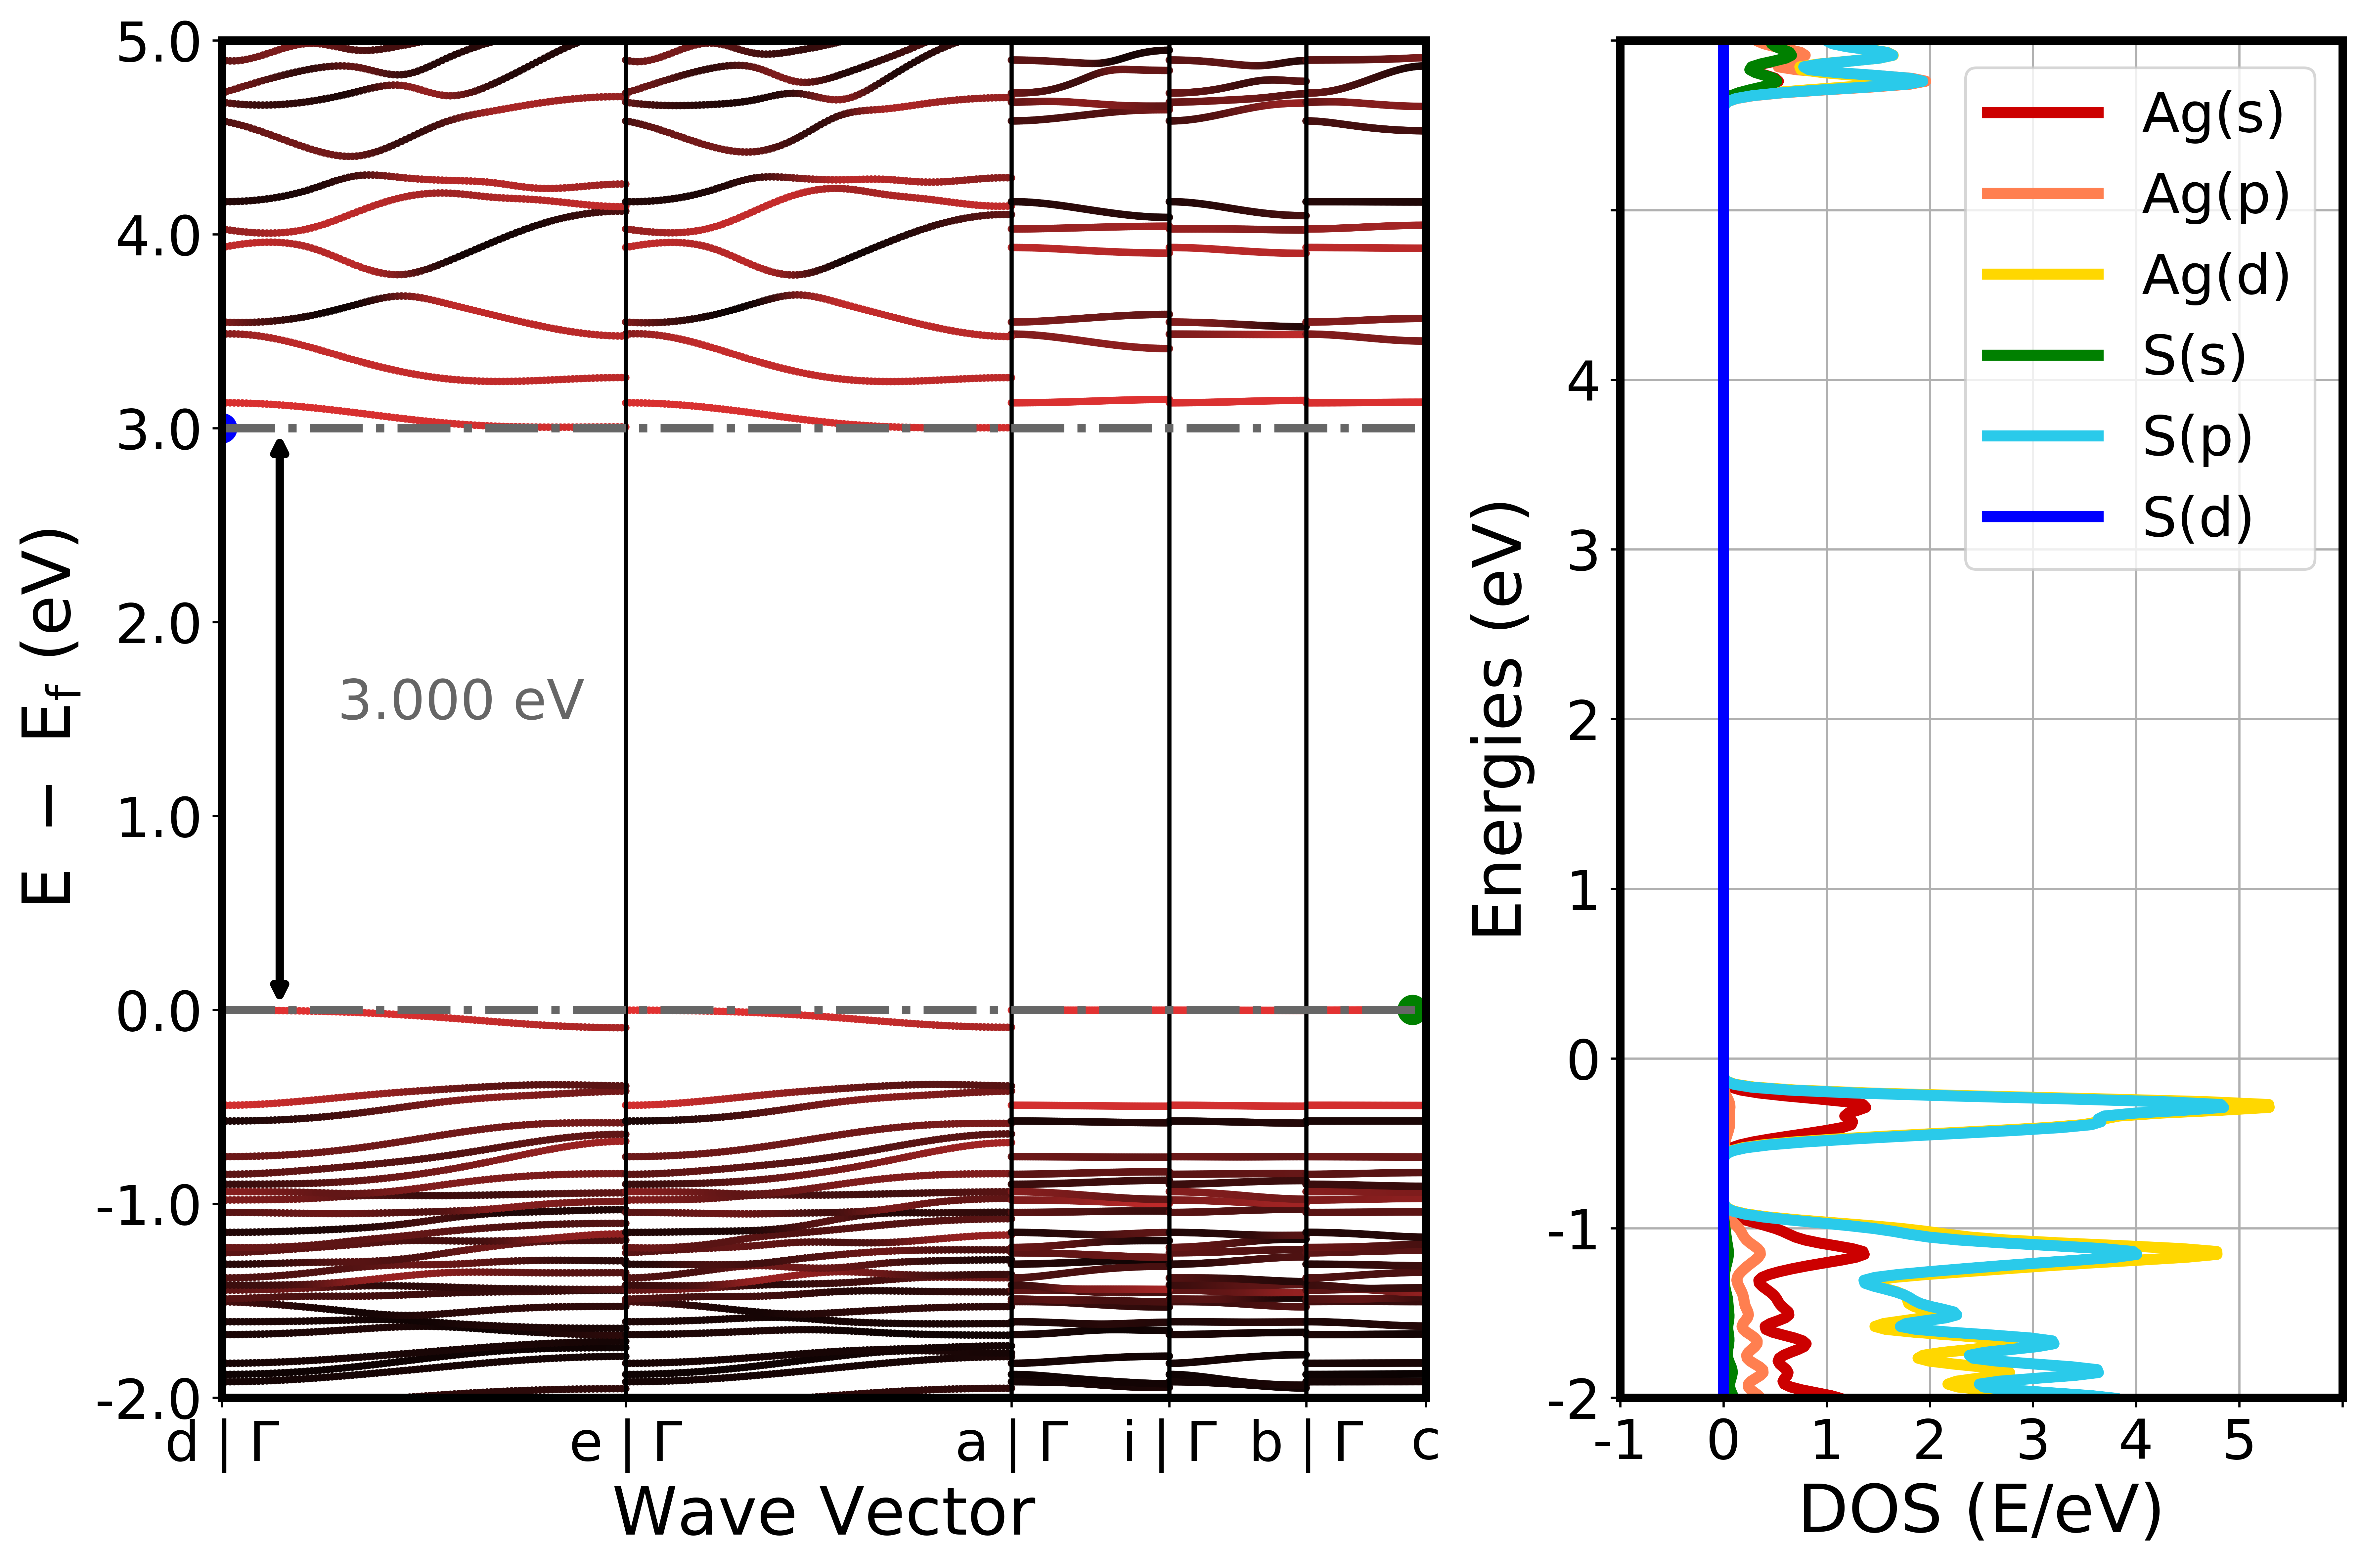

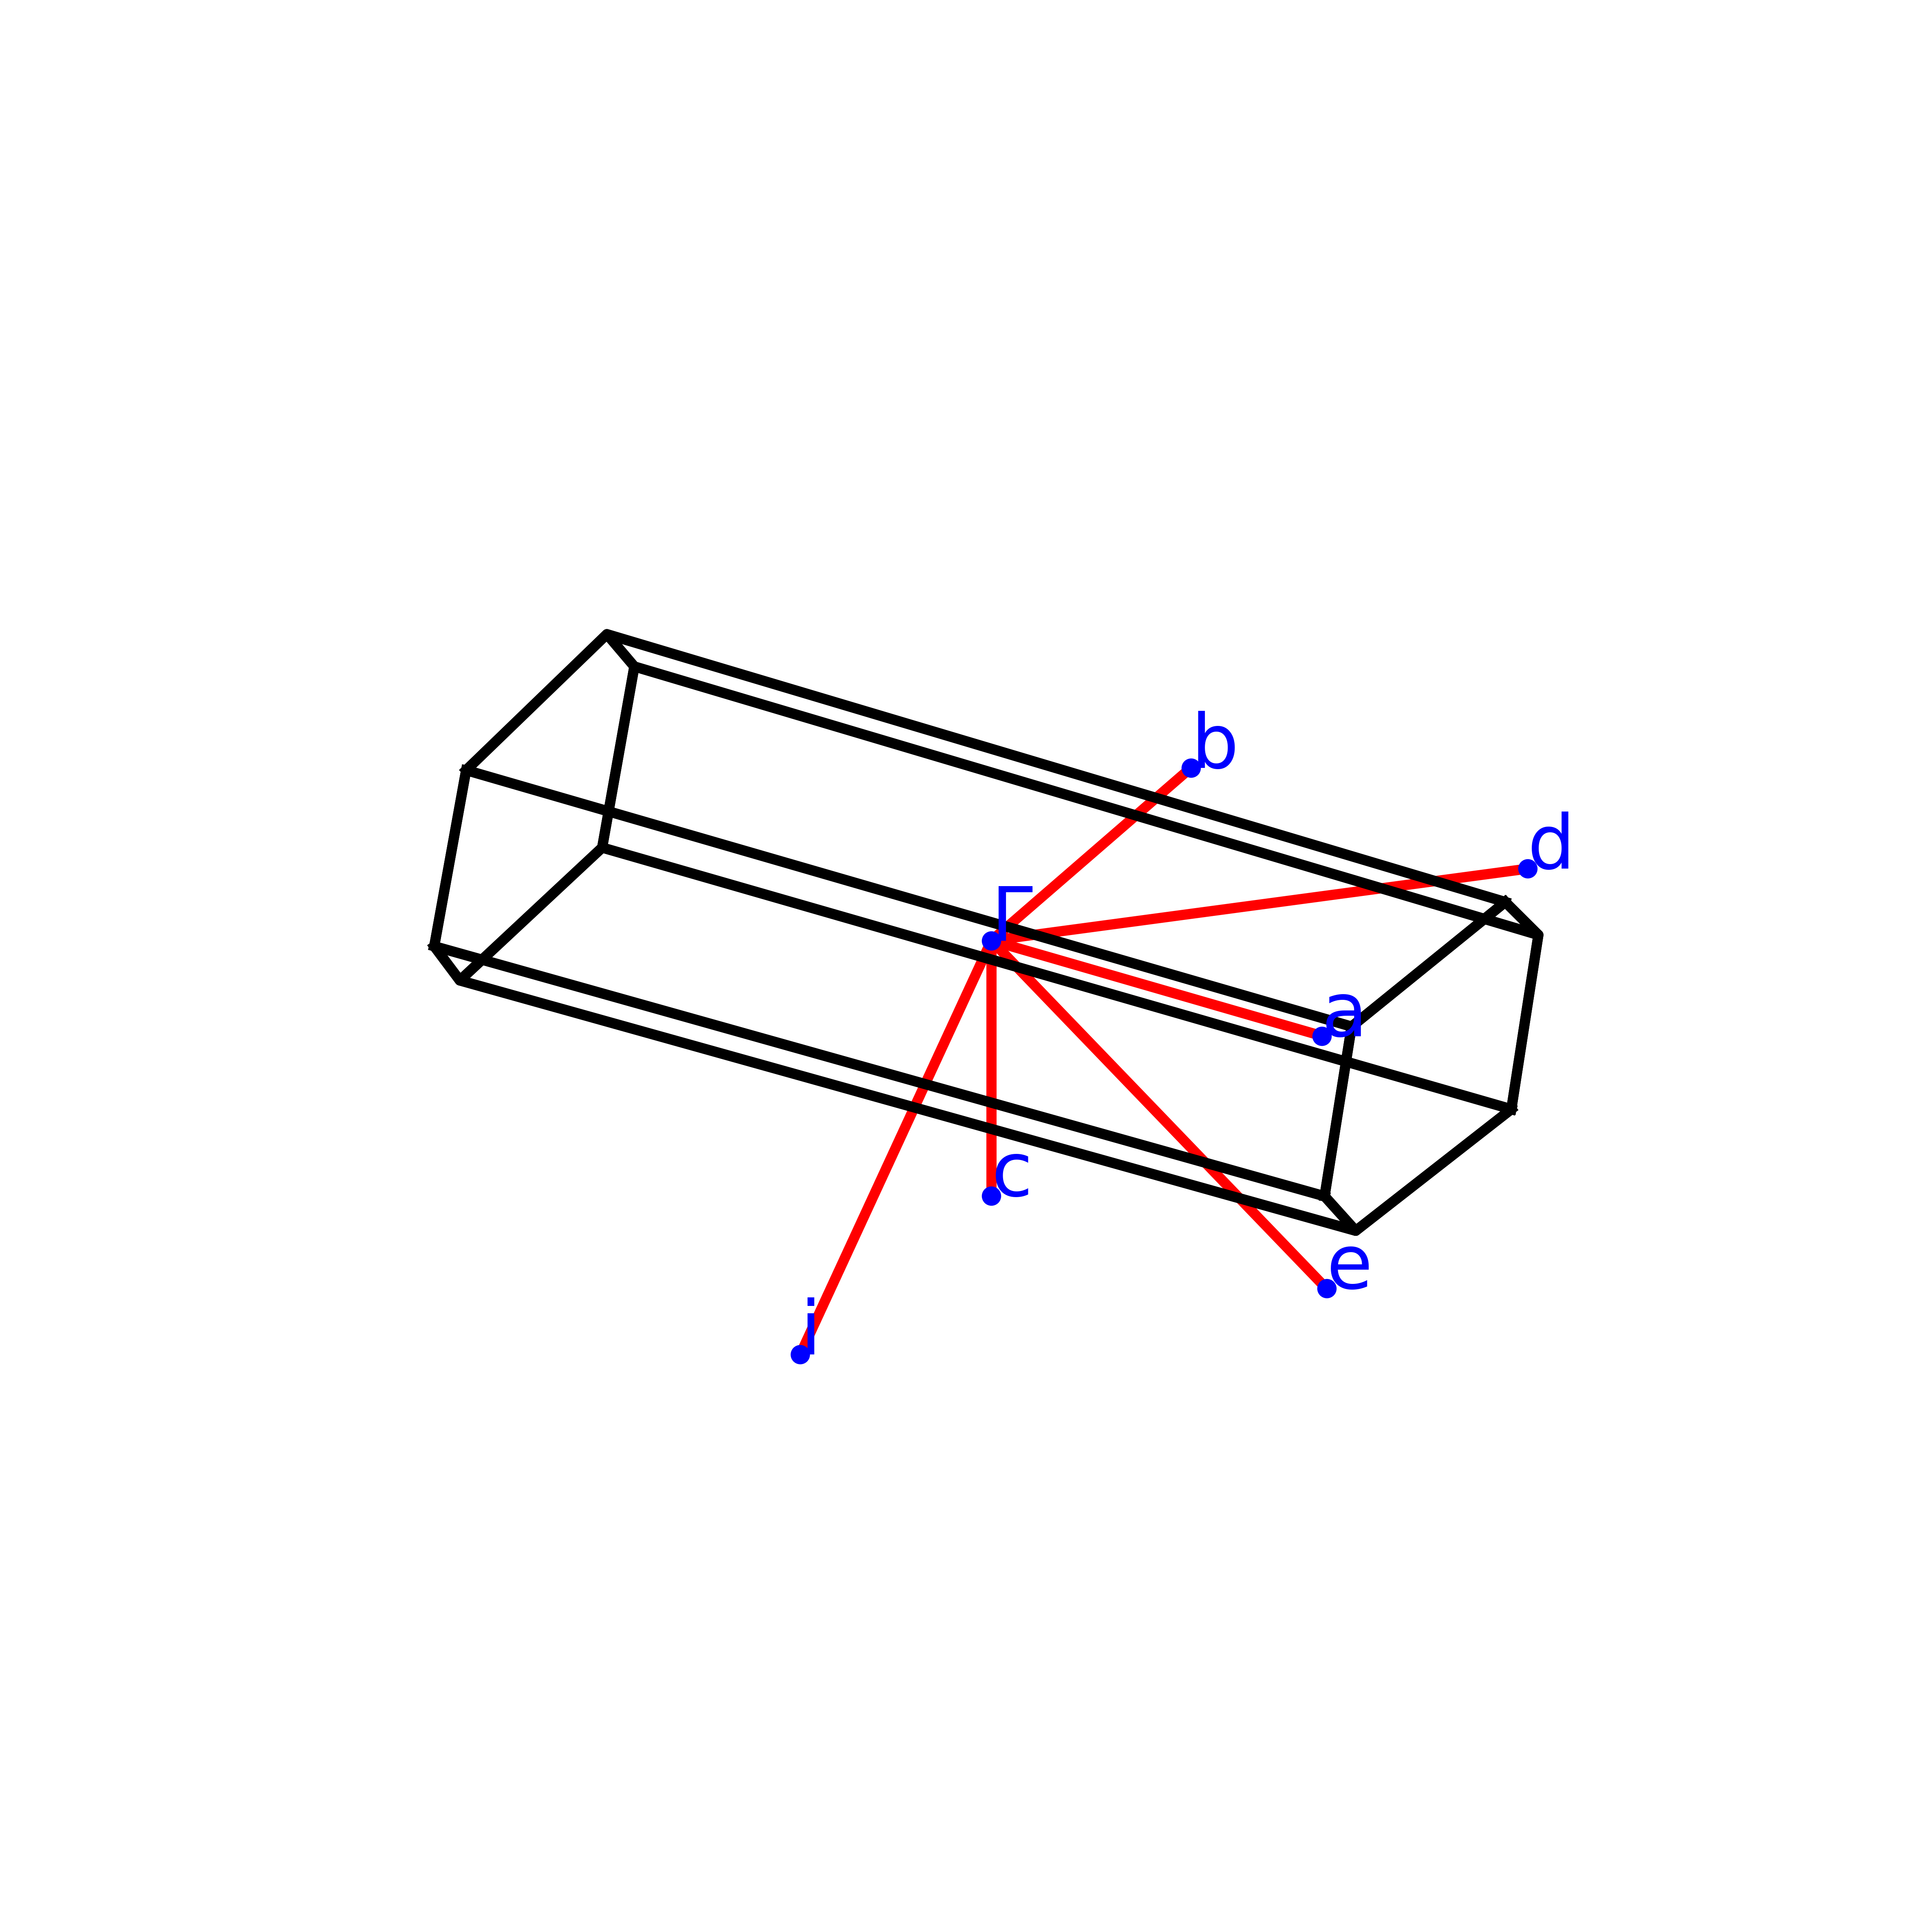

In [100]:
ylim = [-2,5]
dos_xlim = [-1,6]
dos_ylim = [-1,3]
band_xlim = [3,8]
line_width, font_size, marker = 3, 22, 22

# get_color_grouped(root, bsp, smooth=True, marker_size=5, ylim=[-2,5])
# pretty_dos_plot(root, dosplot)
band_labels = color_bs_dos_plotter(root, bsp, plotter, smooth=True, marker_size=3, ylim=ylim, dos_ylim=dos_ylim, dos_xlim=dos_xlim, band_xlim=band_xlim)
sexier_brillouin_plot(root, bsp, band_labels, line_width, font_size, marker)

## Testing out some shit in case the orbital contribution via DOS is needed

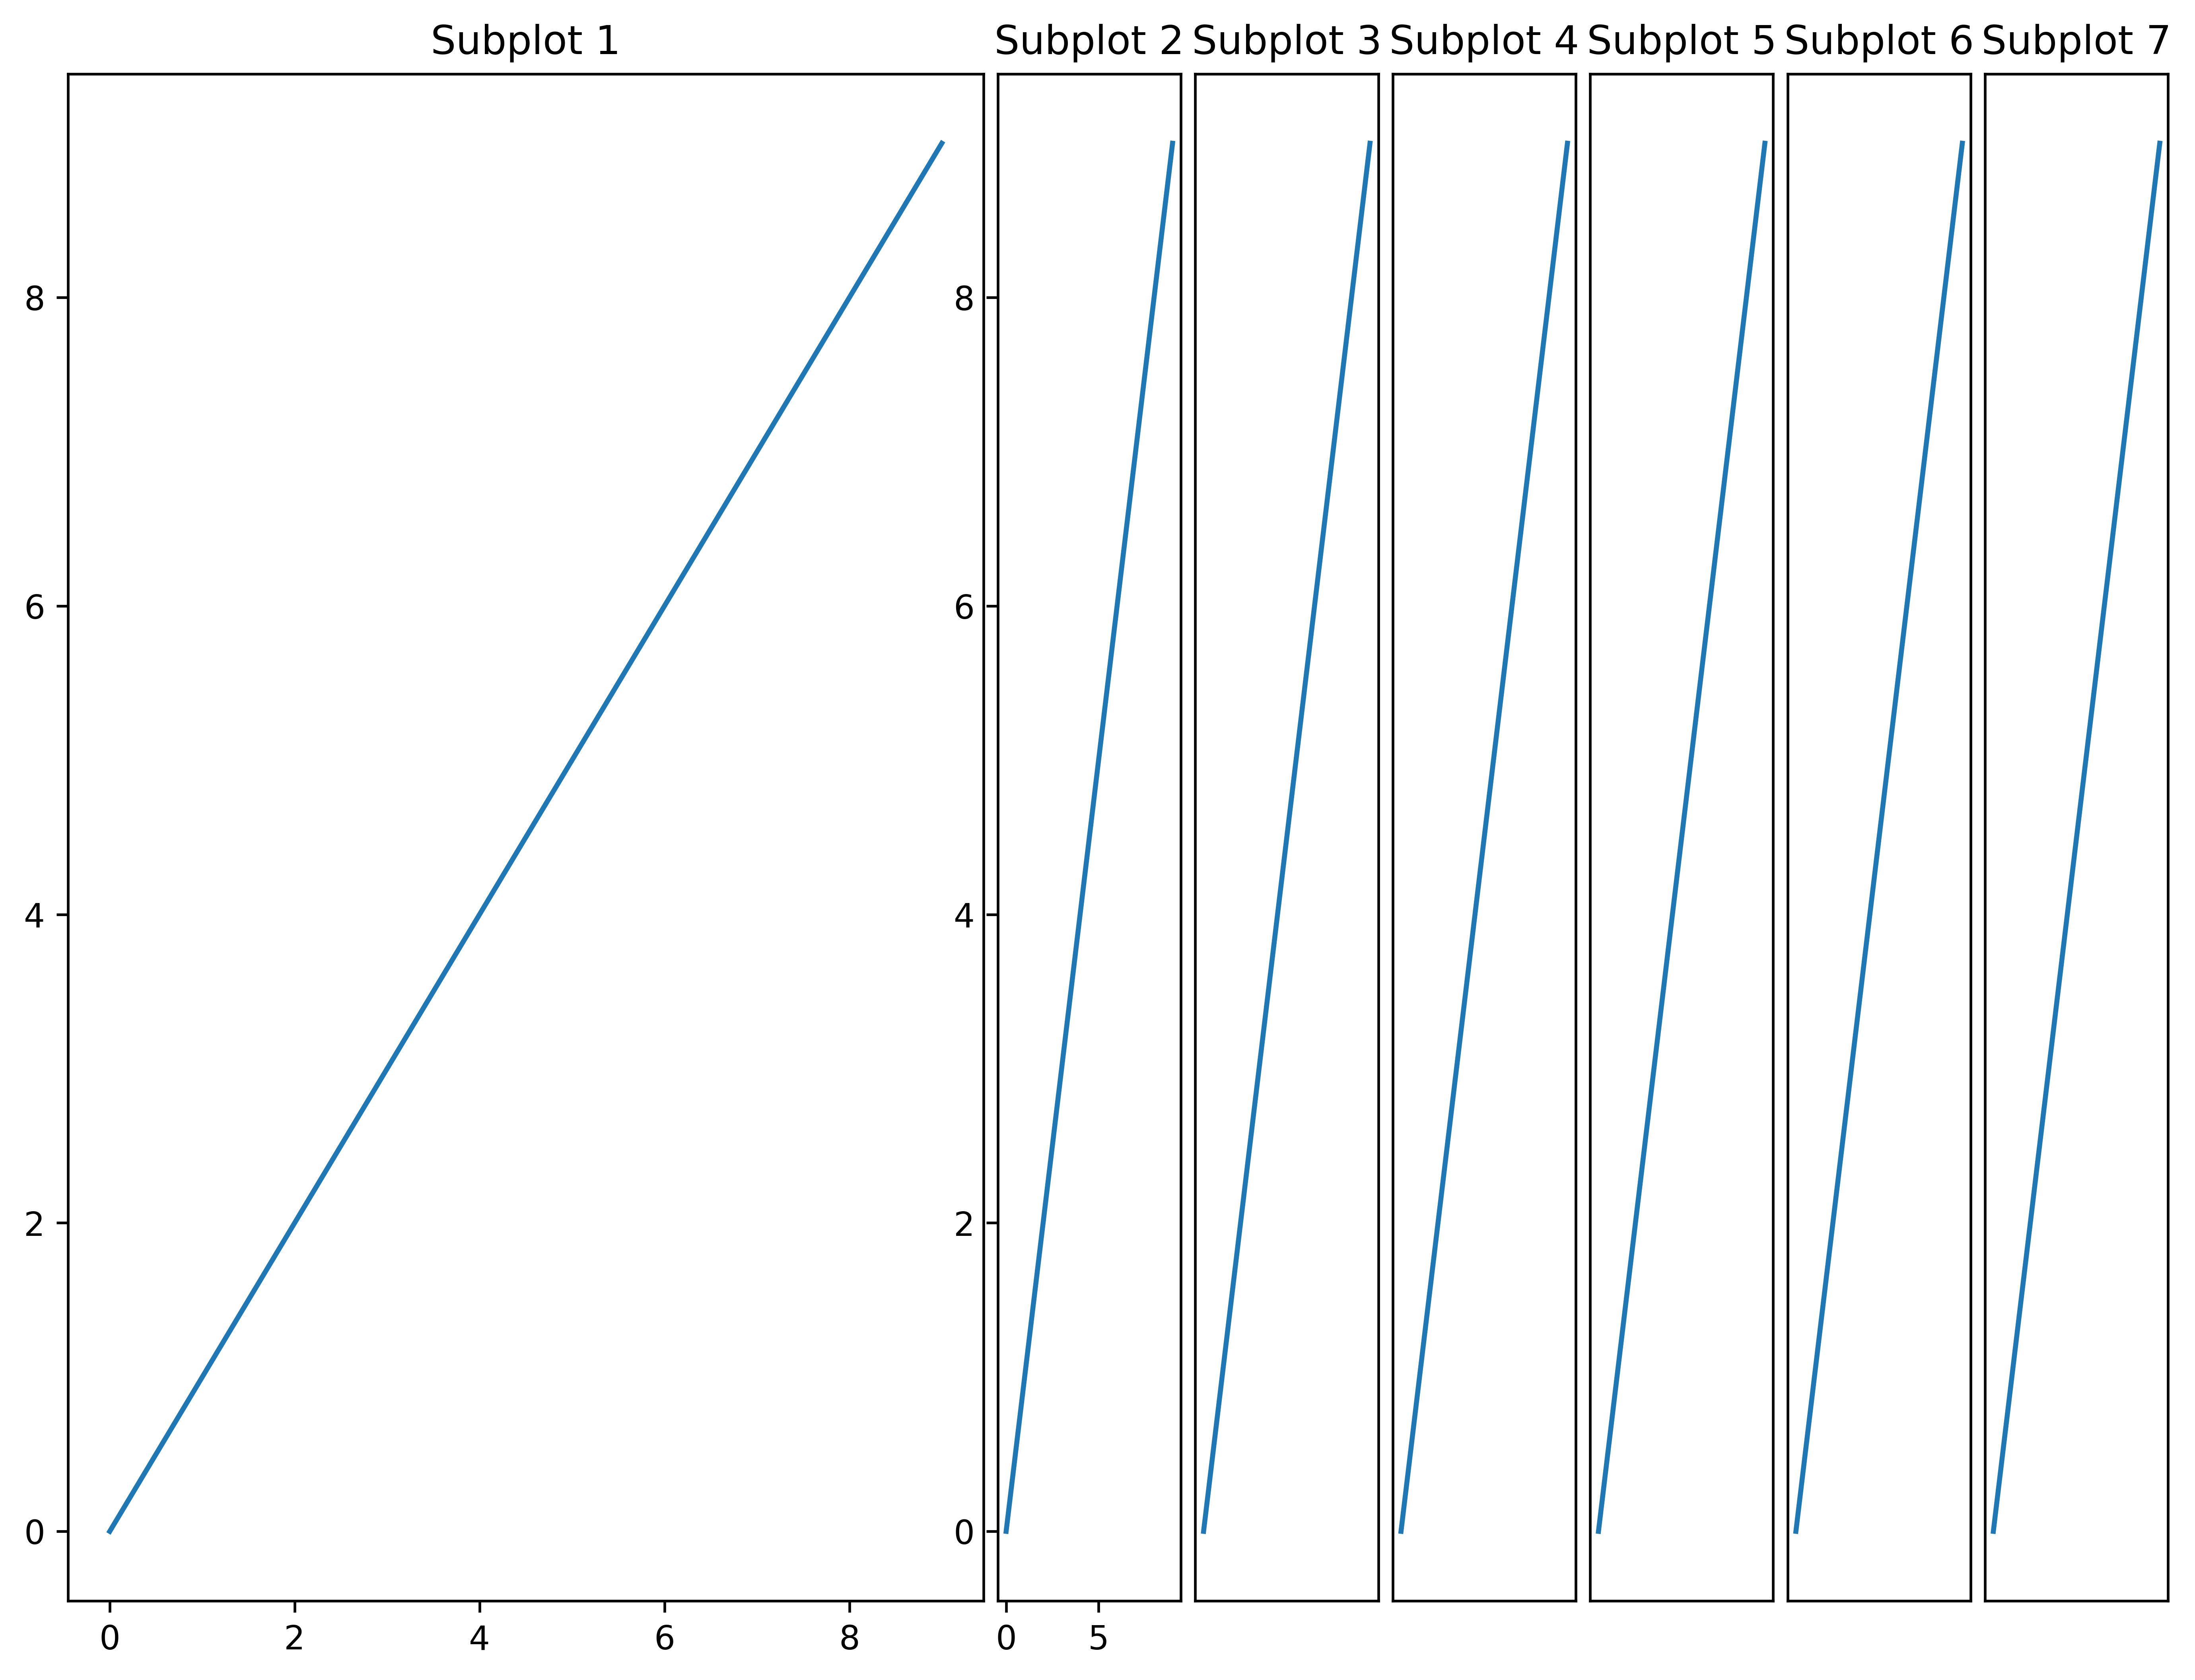

In [41]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create a figure
fig = plt.figure(figsize=(11, 8), dpi=600)

# Create a GridSpec with customized spacing
gs = GridSpec(1, 7, width_ratios=[5, 1, 1, 1, 1, 1, 1], wspace=0.05)

# Create subplots using GridSpec
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[0, 4])
ax6 = fig.add_subplot(gs[0, 5])
ax7 = fig.add_subplot(gs[0, 6])

# Example data to plot
x = range(10)
y = [i for i in x]

# Plot data on each subplot
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
for i, ax in enumerate(axes):
    ax.plot(x, y)  # Replace with your actual plotting code
    ax.set_title(f'Subplot {i+1}')
    if i > 1:  # Remove labels and ticks for all subplots except the first two
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

# Adjust layout
plt.subplots_adjust(wspace=0.05)  # Reduce spacing between subplots 2-7
ax1.figure.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3)  # Increase spacing before subplot 1

# Show the plot
plt.show()
